# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")
import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input\Real\BPI Challenge 2020/*.xes.gz")

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  5


,0
0,Input\Real\BPI Challenge 2020\DomesticDeclarations.xes.gz
1,Input\Real\BPI Challenge 2020\InternationalDeclarations.xes.gz
2,Input\Real\BPI Challenge 2020\PermitLog.xes.gz
3,Input\Real\BPI Challenge 2020\PrepaidTravelCost.xes.gz
4,Input\Real\BPI Challenge 2020\RequestForPayment.xes.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[0]
print(log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_xes(log_path)

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('case:id')))
print("Total activities: ", len(event_log.groupby('concept:name')))
event_log.head()

DomesticDeclarations


parsing log, completed traces :: 100%|██████████| 10500/10500 [00:00<00:00, 10969.52it/s]


Total events:  56437
Total cases:  10500
Total activities:  17


,original_index,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
1,1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
2,2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
3,3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.8512
4,4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.4642


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='case:id', activity_key='concept:name', timestamp_key='time:timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(20)

66937


,case_id,activity_from,timestamp_from,event_order_from,activity_to,timestamp_to,event_order_to,case_order,transition_id
0,declaration 86791,START,2017-01-09 09:49:50+00:00,0,Declaration_SUBMITTED_by_EMPLOYEE,2017-01-09 09:49:50+00:00,0.0000,0,0
1,declaration 86791,Declaration_SUBMITTED_by_EMPLOYEE,2017-01-09 09:49:50+00:00,0,Declaration_FINAL_APPROVED_by_SUPERVISOR,2017-01-09 11:27:48+00:00,1.0000,1,1
2,declaration 86791,Declaration_FINAL_APPROVED_by_SUPERVISOR,2017-01-09 11:27:48+00:00,1,Request_Payment,2017-01-10 09:34:44+00:00,2.0000,2,2
3,declaration 86791,Request_Payment,2017-01-10 09:34:44+00:00,2,Payment_Handled,2017-01-12 17:31:22+00:00,3.0000,3,3
4,declaration 86791,Payment_Handled,2017-01-12 17:31:22+00:00,3,END,2017-01-12 17:31:22+00:00,3.0000,4,4
5,declaration 86795,START,2017-01-09 10:26:14+00:00,4,Declaration_SUBMITTED_by_EMPLOYEE,2017-01-09 10:26:14+00:00,4.0000,0,5
6,declaration 86795,Declaration_SUBMITTED_by_EMPLOYEE,2017-01-09 10:26:14+00:00,4,Declaration_APPROVED_by_PRE_APPROVER,2017-02-22 10:29:21+00:00,5.0000,1,6
7,declaration 86795,Declaration_APPROVED_by_PRE_APPROVER,2017-02-22 10:29:21+00:00,5,Declaration_FINAL_APPROVED_by_SUPERVISOR,2017-02-23 08:14:45+00:00,6.0000,2,7
8,declaration 86795,Declaration_FINAL_APPROVED_by_SUPERVISOR,2017-02-23 08:14:45+00:00,6,Request_Payment,2017-03-06 14:07:25+00:00,7.0000,3,8
9,declaration 86795,Request_Payment,2017-03-06 14:07:25+00:00,7,Payment_Handled,2017-03-13 17:30:59+00:00,8.0000,4,9


## Step 2 - Setting Window Strategy

In [112]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 2000, window_ref_mode = "Fixed", overlap = True, sliding_step = 400, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items()))

{0: {'start': 0, 'end': 2000, 'window_index': 0},
 1: {'start': 400, 'end': 2400, 'window_index': 1},
 2: {'start': 800, 'end': 2800, 'window_index': 2},
 3: {'start': 1200, 'end': 3200, 'window_index': 3},
 4: {'start': 1600, 'end': 3600, 'window_index': 4},
 5: {'start': 2000, 'end': 4000, 'window_index': 5},
 6: {'start': 2400, 'end': 4400, 'window_index': 6},
 7: {'start': 2800, 'end': 4800, 'window_index': 7},
 8: {'start': 3200, 'end': 5200, 'window_index': 8},
 9: {'start': 3600, 'end': 5600, 'window_index': 9},
 10: {'start': 4000, 'end': 6000, 'window_index': 10},
 11: {'start': 4400, 'end': 6400, 'window_index': 11},
 12: {'start': 4800, 'end': 6800, 'window_index': 12},
 13: {'start': 5200, 'end': 7200, 'window_index': 13},
 14: {'start': 5600, 'end': 7600, 'window_index': 14},
 15: {'start': 6000, 'end': 8000, 'window_index': 15},
 16: {'start': 6400, 'end': 8400, 'window_index': 16},
 17: {'start': 6800, 'end': 8800, 'window_index': 17},
 18: {'start': 7200, 'end': 9200, '

## Step 3 - Setting Process Representation (using Transition Matrix)

In [136]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.005
                                    , control_flow_features={'frequency', 'probability'}
                                    , time_features={} 
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation()#.head(15)

frequency  \
activity_from                            activity_to                                           
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER           2820   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR       5133   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR       2788   
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR        674   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                               10038   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE                928   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE              1081   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION         8202   
                                         Declaration_APPROVED_by_PRE_APPROVER            685   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR       1536   
                                         Declaration_REJECTED_by_ADMINISTRATION          952   
Payment_Handled                          END                                           10043   
Request_Payment                          Payment_Handled                               10037   
START                                    Declaration_SUBMITTED_by_EMPLOYEE             10365   

                                                                                   percentual  \
activity_from                            activity_to                                            
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER          0.0421   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0767   
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0417   
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0101   
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                               0.1500   
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE              0.0139   
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE             0.0161   
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION        0.1225   
                                         Declaration_APPROVED_by_PRE_APPROVER          0.0102   
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR      0.0229   
                                         Declaration_REJECTED_by_ADMINISTRATION        0.0142   
Payment_Handled                          END                                           0.1500   
Request_Payment                          Payment_Handled                               0.1499   
START                                    Declaration_SUBMITTED_by_EMPLOYEE             0.1548   

                                                                                   probability  
activity_from                            activity_to                                            
Declaration_APPROVED_by_ADMINISTRATION   Declaration_APPROVED_by_BUDGET_OWNER           0.3546  
                                         Declaration_FINAL_APPROVED_by_SUPERVISOR       0.6454  
Declaration_APPROVED_by_BUDGET_OWNER     Declaration_FINAL_APPROVED_by_SUPERVISOR       1.0000  
Declaration_APPROVED_by_PRE_APPROVER     Declaration_FINAL_APPROVED_by_SUPERVISOR       1.0000  
Declaration_FINAL_APPROVED_by_SUPERVISOR Request_Payment                                1.0000  
Declaration_REJECTED_by_ADMINISTRATION   Declaration_REJECTED_by_EMPLOYEE               1.0000  
Declaration_REJECTED_by_EMPLOYEE         Declaration_SUBMITTED_by_EMPLOYEE              1.0000  
Declaration_SUBMITTED_by_EMPLOYEE        Declaration_APPROVED_by_ADMINISTRATION         0.7211  
                       

## Step 4 - Setting Change Representation

In [137]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head()

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,2000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,400,2400,1,0,143.0000,2.2130,0.0363,28.0077,1.0000,0.0000
2,800,2800,2,0,167.0000,2.2851,0.0425,31.2720,1.0000,0.0000
3,1200,3200,3,0,166.0000,2.2597,0.0422,32.8314,1.0000,0.0000
4,1600,3600,4,0,215.0000,2.3793,0.0547,38.9210,1.0000,0.0000


## Step 5 - Setting Detection Task

In [138]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[32, 72, 126, 153, 163]"
1,time_series_strategy,cpd_prob_freq_delta,"[26, 33, 85, 130, 163]"
2,time_series_strategy,cramersv_frequency,[163]
3,threshold_strategy,gtest_frequency,[163]


In [139]:
### Grounding truth
# No ground truth available for real dataset. Skipping this step.

In [140]:
### Validation metrics
# No ground truth available for real dataset. Skipping validation metrics calculation.

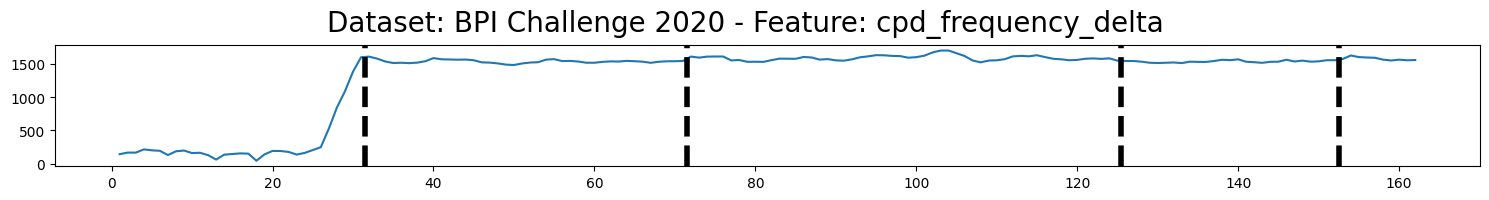

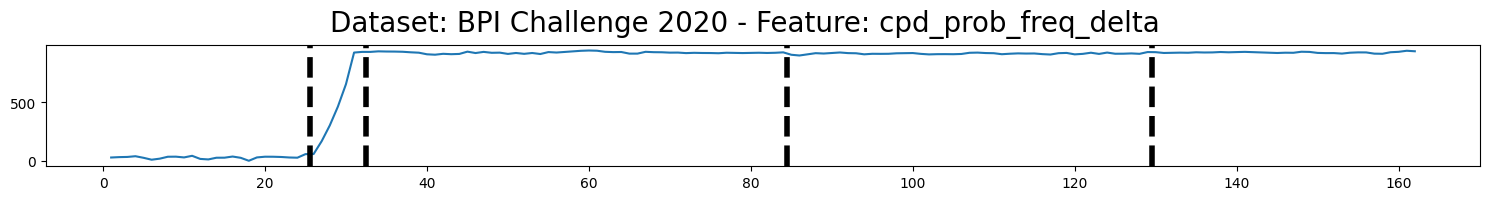

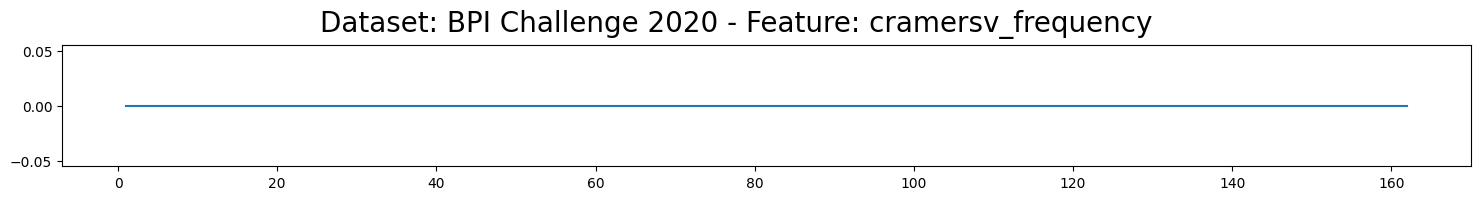

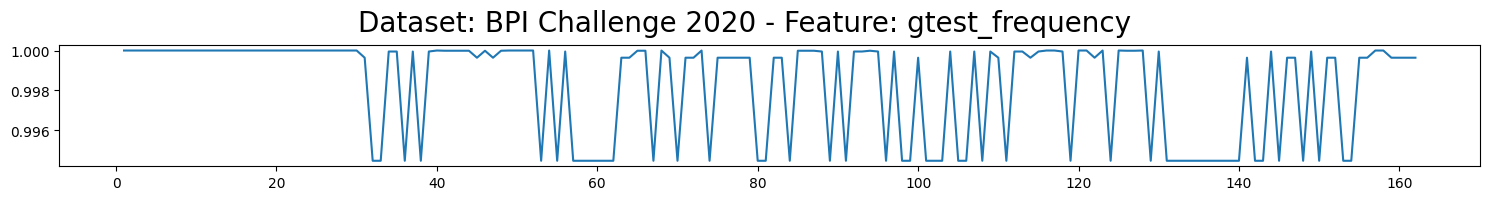

In [141]:
### Display Detection Task Results 
detection_task_results = TMPD_instance.get_detection_task()
for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(
        signal=TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']],
        true_chg_pts=[],  # Provide empty list when no ground truth
        computed_chg_pts=result.detection_results,
        computed_chg_pts_color="k",
        computed_chg_pts_linewidth=4,
        computed_chg_pts_linestyle="--",
        computed_chg_pts_alpha=1,
        figsize=(15, 2)
    )
    plt.suptitle(
        "Dataset: " + log_path.split("\\")[-2]
        + " - Feature: " + result.detection_feature,
        fontsize=20
    )
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

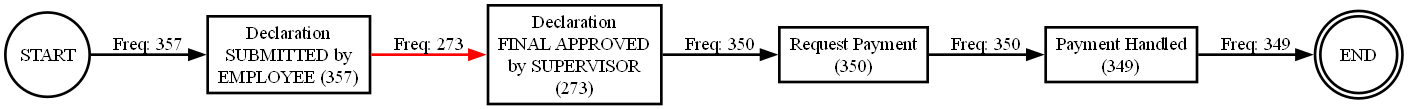

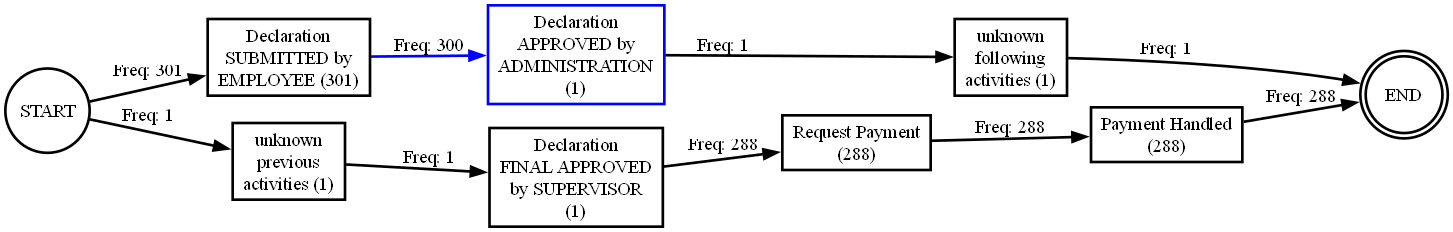

(Empty DataFrame
 Columns: [transition, feature, p_value, effect_size, ref_value, det_value, dif_value]
 Index: [],
 {'Transitions with variations in frequency': ['None'],
  'Transitions with variations in probability': ['None'],
  'Transitions with variations in percentual': ['None'],
  'New transitions added to the process': [('Declaration_SUBMITTED_by_EMPLOYEE',
    'Declaration_APPROVED_by_ADMINISTRATION')],
  'Deleted transitions from the process': [('Declaration_SUBMITTED_by_EMPLOYEE',
    'Declaration_FINAL_APPROVED_by_SUPERVISOR')],
  'New activities added to the process': ['Declaration_APPROVED_by_ADMINISTRATION'],
  'Deleted activities from the process': ['None']},
 "Sequence( 'Declaration_SUBMITTED_by_EMPLOYEE', 'Declaration_FINAL_APPROVED_by_SUPERVISOR', 'Request_Payment', 'Payment_Handled' )",
 "Conditional( Sequence( 'unknown_previous_activities', 'Declaration_FINAL_APPROVED_by_SUPERVISOR', 'Request_Payment', 'Payment_Handled' ), Sequence( 'Declaration_SUBMITTED_by_EMPLOY

In [135]:
# Setting Localization Task
TMPD_instance.set_localization_task(reference_window_index=0, detection_window_index=55, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=False)

In [13]:
### Ground Truth
# No ground truth available for localization task in real dataset.

In [14]:
### Validation metrics
# No ground truth available for localization task in real dataset. Skipping validation metrics calculation.

In [15]:
# # Skip Pattern temporary test
# TMPD_instance.detection_bpmn_text = "Sequence( 'Loan__application_received', Loop( 'Check__application__form_completeness', Sequence( 'Return_application_back_to_applicant', 'Receive_updated_application' ) ), Parallel( 'Appraise_property', Sequence( 'Check_credit_history', 'Assess_loan_risk' ) ), 'Assess_eligibility', Conditional( Sequence( Conditional( Sequence( 'Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested') , 'tau'), Conditional( 'Send_acceptance_pack', 'Send_home_insurance_quote' ), 'Verify_repayment_agreement', Conditional( Sequence( 'Cancel_application', 'Loan__application_canceled' ), Sequence( 'Approve_application', 'Loan__application_approved' ) ) ), Sequence( 'Reject_application', 'Loan_application_rejected' ) ) )"
# TMPD_instance.detection_bpmn_text

## Step 6b - Setting Characterization Task

In [16]:
# Setting Characterization Task
# TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v0.yaml') # "gpt-4o", "gpt-3.5-turbo-0125", "gpt-4"
TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.0-flash", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v1.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
TMPD_instance.get_characterization_task()

################################ llm_bpmn_analysis_prompt #####################################
### Introduction ###
You are a technical analyst specializing in concept drift in process mining. 
Your primary role is to investigate the phenomenon of concept drift by comparing two distinct phases of a business process: the reference window (before the change) and the detection window (after the change).


### BPMN Diagrams Comparison ###
You will be provided with detailed BPMN diagrams for both time frame (reference and detection windows).

Familiarize yourself with the BPMN symbols used in the diagrams:
    - Control-flow operators:
        - Sequence fragments are denoted by 'Sequence'. Each item in a sequence fragment will be executed in order.
        - Parallel fragments by 'Parallel'. Each item in a parallel fragment will be executed, but not necessarily in order.
        - Conditional fragments by 'Conditional'. Only one item in a conditional fragment will be executed.
        - L

('Classification not in the expected format.',
 "### Change Characterization Analysis ###\n\n1.  **Holistic Explanation and Correlation of Findings:**\n\nThe analysis reveals a significant concept drift in the process, characterized by substantial changes in activity execution and control flow. Several activities have been added and removed, and the process flow has been altered by moving activities and control-flow operators.\n\n*   **Activity Changes:** The deletion of 'unknown\\_previous\\_activities', 'Declaration\\_REJECTED\\_by\\_SUPERVISOR', 'Declaration\\_REJECTED\\_by\\_PRE\\_APPROVER', 'Declaration\\_REJECTED\\_by\\_MISSING', and 'Declaration\\_APPROVED\\_by\\_PRE\\_APPROVER' indicates a streamlining or removal of specific approval steps. The addition of 'Declaration\\_APPROVED\\_by\\_ADMINISTRATION' and 'Declaration\\_APPROVED\\_by\\_BUDGET\\_OWNER' suggests the introduction of new approval layers within the process.\n*   **Control-Flow Changes:** The movement of the Loop fr

In [17]:
### Ground Truth
# No ground truth available for characterization task in real dataset.


In [18]:
### Validation metrics
# No ground truth available for characterization task in real dataset. Skipping validation metrics calculation.


In [19]:
# Skipping summary of understanding tasks results, as there is no ground truth for real dataset.

## Step 6c - Setting Explanation Task

In [20]:
# TODO